In [3]:
import glob
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import seawater as sw
from scipy import linalg
import gsw
import sys
sys.path.append('/Users/paban23/Research/PhD/S-MODE/S-MODE-IOP/IOP_codes')
#sys.path.insert(0,'/home/pab21003/PhD/Practice/NRT/Maps-main/tools/')
from itertools import combinations
# from utils import *
from utils import *
# from spectra_utils import *
from scipy import signal
from scipy.special import gammainc
from scipy.stats import kurtosis, skew

In [4]:
ds = xr.open_dataset('../Data/sigma_delta_u_IOP1_subset.nc')
ds

<xarray.Dataset>
Dimensions:           (averaging_window: 599)
Coordinates:
  * averaging_window  (averaging_window) int64 1 2 3 4 5 ... 595 596 597 598 599
Data variables:
    sig_del_u_1026    (averaging_window) float64 ...
    sig_del_u_1048    (averaging_window) float64 ...
    sig_del_u_1085    (averaging_window) float64 ...
    sig_del_u_1087    (averaging_window) float64 ...

In [5]:
ds_p = xr.open_dataset('../Data/sigma_delta_u_Pilot_1072_subset.nc')
ds_p

<xarray.Dataset>
Dimensions:           (averaging_window: 599)
Coordinates:
  * averaging_window  (averaging_window) int64 1 2 3 4 5 ... 595 596 597 598 599
Data variables:
    sig_del_u_1072    (averaging_window) float64 ...

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

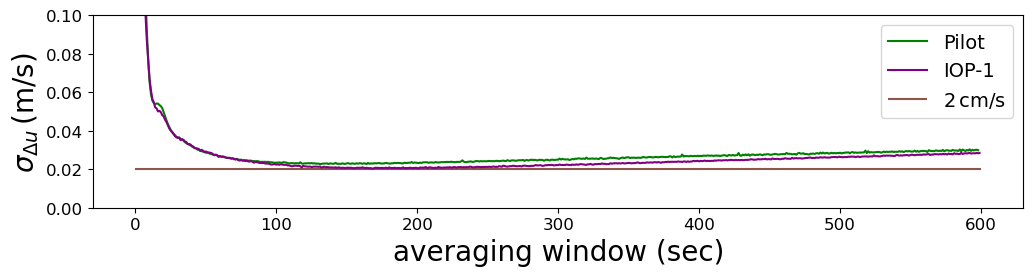

In [7]:
fig,ax = plt.subplots(1,1,figsize=(12,2.5))
clrs = ['purple','m','navy','maroon','g','saddlebrown','coral',]
plt.plot(ds_p.sig_del_u_1072,color=clrs[4])
ds.sig_del_u_1085.plot(color=clrs[0])


#plt.plot(np.arange(1,600),np.ones_like(np.arange(1,600))*0.025)
plt.hlines(0.02,0,600,color='C5')
plt.legend((r'Pilot','IOP-1','2$\,$cm/s'),fontsize=14)
plt.ylabel(r'$\sigma_{\Delta u}\,$(m/s)',fontsize=20)
plt.xlabel(r'averaging window (sec)',fontsize=20)
plt.ylim(0,0.1)
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.savefig('../Plots/std_of_delu_1072_1085_without_dx_large_ticks.png',dpi=200,bbox_inches='tight')

## Save $\sigma_{\delta u}$ data

In [3]:
all_ds = ['sd_all','sd_all_15sec','sd_all_30sec','sd_all_1min','sd_all_2min','sd_all_5min']

In [5]:
t4s, t4e = '2021-11-06T12:40:00.000000000','2021-11-06T15:20:00.000000000'  #'2021-11-04T12:45','2021-11-06T18:44'
t5s, t5e = '2021-11-06T15:20:00.000000000', '2021-11-06T21:10:00.000000000'   

In [ ]:
## Load 1hz 1073 files

files = sorted(glob.glob('/Users/paban23/Research/PhD/S-MODE/Pilot/Data/ADCP/1072/1hz/*.nc'))

# loop over files and aggregate datasets
for file in files:
    if file == files[0]:
        sd=  xr.open_dataset(file).isel(trajectory=0)#.sel(cell_depth=slice(7.9,50))
    else:
        sd= xr.concat([sd, xr.open_dataset(file).isel(trajectory=0)],dim='obs') #.sel(cell_depth=slice(7.9,50))

sd = sd.rename({'vel_east': 'u', 'vel_north': 'v'}).swap_dims({'obs':'time'})
sd = sd.reset_coords(['longitude', 'latitude'])#.swap_dims({'obs':'time'})

In [ ]:
sd_all_p = sd.sortby('time') 

In [ ]:
sd_all_sub = xr.concat([sd_all_p.sel(time=slice(t4s,t4e)).drop_duplicates('time'),\
                     sd_all_p.sel(time=slice(t5s,t5e)).drop_duplicates('time')],
                       dim="legs").isel(cell_depth=np.arange(0,24)) #trajectory=2

In [9]:
sd_all_sub

<xarray.Dataset>
Dimensions:              (time: 30511, cell_depth: 24, legs: 2, beam: 4)
Coordinates:
  * time                 (time) datetime64[ns] 2021-11-06T12:40:00 ... 2021-1...
  * cell_depth           (cell_depth) float64 3.9 5.9 7.9 9.9 ... 45.9 47.9 49.9
    trajectory           float32 1.072e+03
Dimensions without coordinates: legs, beam
Data variables: (12/30)
    latitude             (legs, time) float64 37.22 37.22 37.22 ... 37.22 37.22
    longitude            (legs, time) float64 -123.5 -123.5 ... -123.7 -123.7
    roll                 (legs, time) float64 7.663 11.06 ... -6.641 -12.53
    pitch                (legs, time) float64 -1.203 -0.9229 ... 0.7965 -4.779
    heading              (legs, time) float64 148.2 144.1 143.6 ... 283.7 279.3
    u                    (legs, time, cell_depth) float64 -0.243 ... -0.339
    ...                   ...
    bt_vel_up            (legs, time) float64 nan nan nan nan ... nan nan nan
    bt_amp               (legs, time, beam) float64 nan nan nan ... nan nan nan
    bt_percent_good      (legs, time, beam) float64 nan nan nan ... nan nan nan
    percent_good_4_beam  (legs, time, cell_depth) float64 100.0 100.0 ... 100.0
    percent_good_3_beam  (legs, time, cell_depth) float64 0.0 0.0 ... 0.0 0.0
    percent_good         (legs, time, cell_depth) float64 100.0 100.0 ... 100.0
Attributes: (12/38)
    description:                     Saildrone NetCDF Format
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        ADCP,Saildrone
    geospatial_vertical_units:       meters
    geospatial_lon_units:            degrees_east
    geospatial_lat_units:            degrees_north
    ...                              ...
    geospatial_lat_max:              37.78628728352487
    geospatial_lon_min:              -125.50924681127071
    geospatial_lon_max:              -125.50646209158003
    geospatial_vertical_positive:    down
    wmo_id:                          1801588
    license:                         2021 © SAILDRONE Inc.  All Rights Reserv...

In [ ]:
# CALCULATE SIGMA DELTA U FOR 2-599 SECONDS SAMPLING WINDOW FOR 4SDs
for isd in range(1):
    isd = str(isd)
    exec('del_u1072'+ '= [basic_stats(sd_all_sub.resample(time="%ss"%i).mean(dim="time").u.isel(cell_depth=slice(0,24)).diff("time").stack(z =("time","cell_depth","legs")).values)[1] for i in range(2,600,1)]',globals())

In [ ]:
# CONCAT 1HZ SIGMA DELTA U WITH THAT OF THE OTHER AVERAGING WINDOWS
for isd in range(1):
    isd = str(isd)
    exec('del_u11072'+ ' = np.hstack([basic_stats(sd_all_sub.u.isel(cell_depth=slice(0,24)).diff("time").stack(z =("time","cell_depth","legs")).values)[1],del_u1072'+'])',globals())
    

In [47]:
sigma_del_u = xr.Dataset({
'sig_del_u_1026' : xr.DataArray(
               data=del_u11026,
               coords={'averaging_window':np.arange(1,600,1)}, attrs={'time':'seconds'}),
'sig_del_u_1048' : xr.DataArray(
               data=del_u11048,
               coords={'averaging_window':np.arange(1,600,1)}, attrs={'time':'seconds'}),
'sig_del_u_1085' : xr.DataArray(
               data=del_u11085,
               coords={'averaging_window':np.arange(1,600,1)}, attrs={'time':'seconds'}),
'sig_del_u_1087' : xr.DataArray(
               data=del_u11087,
               coords={'averaging_window':np.arange(1,600,1)}, attrs={'time':'seconds'}),
               })

In [20]:
sigma_del_u = xr.Dataset({
'sig_del_u_1072' : xr.DataArray(
               data=del_u11072,
               coords={'averaging_window':np.arange(1,600,1)}, attrs={'time':'seconds'})})